In [1]:
import sys
sys.path.append("gpib_instrument_control")
import hp_3478a
import hp_8700_series_vna
import numpy as np
import time
import yig_controller_test
import matplotlib.pyplot as plt
import scipy.io as sio
import skrf.network

plt.rcParams['figure.figsize'] = [15, 10]


yigControllerPort='/dev/ttyUSB0'
vna = hp_8700_series_vna.Hp8753A()
curMeter = hp_3478a.Hp3478A()
yc = yig_controller_test.YigController(yigControllerPort)

Waiting for init... Done


In [2]:
wr = np.arange(-32768, 32767, 128)
yigChs = range(6)

zeros = []
channels=[]
for c in yigChs:
    yc.yigA.set(c, wr[0])
    time.sleep(5);
    current=[]
    for w in wr:
        yc.yigA.set(c, w);
        #time.sleep(0.5)
        current.append(curMeter.readValue())
    channels.append(current)
    yc.yigA.set(6, 0)
    time.sleep(3)
    zeros.append(curMeter.readValue())
        


In [3]:
import scipy.io as sio
sio.savemat('yig_filter_driver_current_data.mat', {'zeros':zeros, 'channels':channels, 'wr':wr})

In [2]:
d=sio.loadmat('yig_filter_driver_current_data.mat')
zeros=d['zeros'][0]
channels=d['channels']
wr=d['wr'][0]

In [3]:
print(zeros)

[0.27415 0.27481 0.27493 0.27429 0.27411 0.27424]


Filter 0 has current from 0.014070 to 0.086460 [A] in control word range -20352 - 29696 [LSB]
Filter 1 has current from 0.024290 to 0.244630 [A] in control word range -22784 - 31360 [LSB]
Filter 2 has current from 0.028160 to 0.285770 [A] in control word range -22912 - 31360 [LSB]
Filter 3 has current from 0.052230 to 0.485010 [A] in control word range -23040 - 23552 [LSB]
Filter 4 has current from 0.095520 to 1.101550 [A] in control word range -23168 - 31360 [LSB]
Filter 5 has current from 0.095940 to 0.841300 [A] in control word range -23168 - 17408 [LSB]


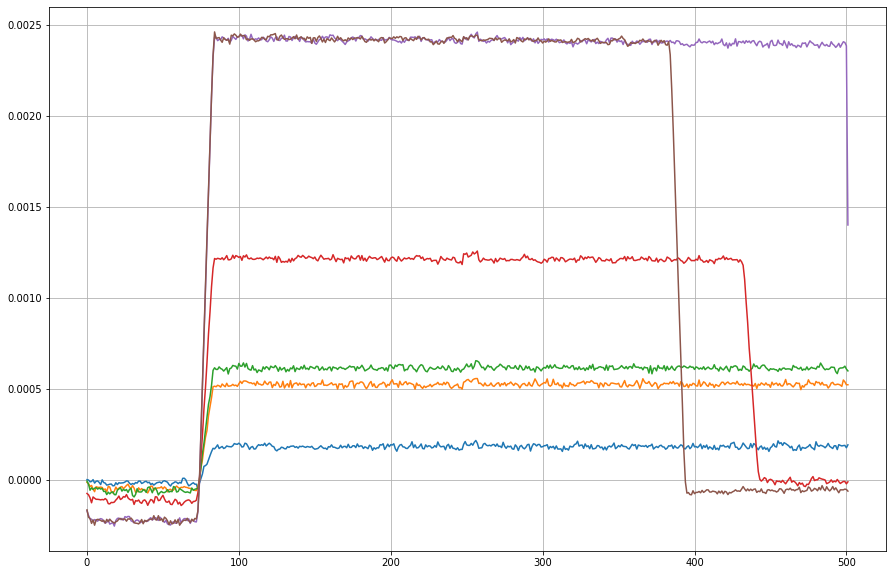

In [4]:
charr = np.array(channels)
def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w

class FilterParameters:
    def __init__(self, lc, hc, lw, hw):
        self.lc=lc
        self.hc=hc
        self.lw=lw
        self.hw=hw

        
fParams=[]
for i in range(len(zeros)):
    avgd = moving_average(np.diff(charr[i,:]), 10)
    plt.plot(avgd)
    plt.grid(True)
    idxs = np.where(avgd>0.0002);
    mii=idxs[0][0]
    mai=idxs[0][-1]
    zc = zeros[i]
    mic=charr[i,mii]-zc
    mac=charr[i,mai]-zc
    #print(idxs[0])
    print("Filter %i has current from %f to %f [A] in control word range %d - %d [LSB]"%(i, mic, mac, wr[mii], wr[mai]))
    fParams.append(FilterParameters(mic, mac, wr[mii], wr[mai]))
    

Filter 0
[0.00000e+00 9.93500e+07 1.98700e+08 1.49025e+08 1.98700e+08 1.49025e+08
 1.98700e+08]
Filter 1
[3.47725e+08 5.46425e+08 5.46425e+08 5.96100e+08 5.46425e+08 5.46425e+08
 5.46425e+08]
Filter 2
[-9.93500e+08  6.95450e+08  5.96100e+08  6.45775e+08  6.45775e+08
  6.95450e+08  6.45775e+08]
Filter 3
[9.935000e+08 1.092850e+09 1.092850e+09 1.142525e+09 1.092850e+09
 1.092850e+09 1.092850e+09]
Filter 4
[2.136025e+09 2.583100e+09 2.583100e+09 2.583100e+09 2.583100e+09
 2.533425e+09 2.483750e+09]
Filter 5
[1.837975e+09 2.285050e+09 2.285050e+09 2.285050e+09 2.285050e+09
 2.235375e+09 2.235375e+09]
0.428050 to 1.421550 [GHz]
0.577075 to 4.253025 [GHz]
1.024150 to 4.948475 [GHz]
0.825450 to 8.425725 [GHz]
1.769275 to 19.254875 [GHz]
1.967975 to 17.416900 [GHz]


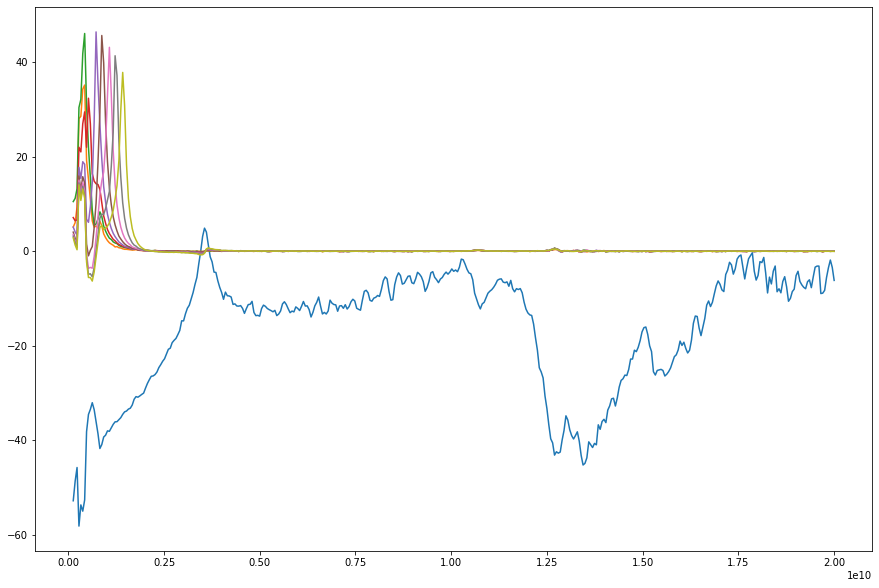

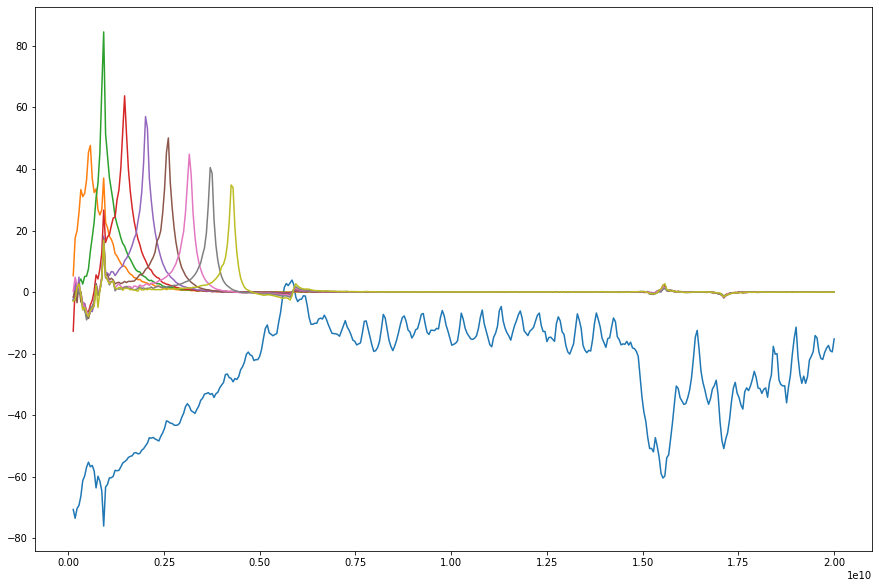

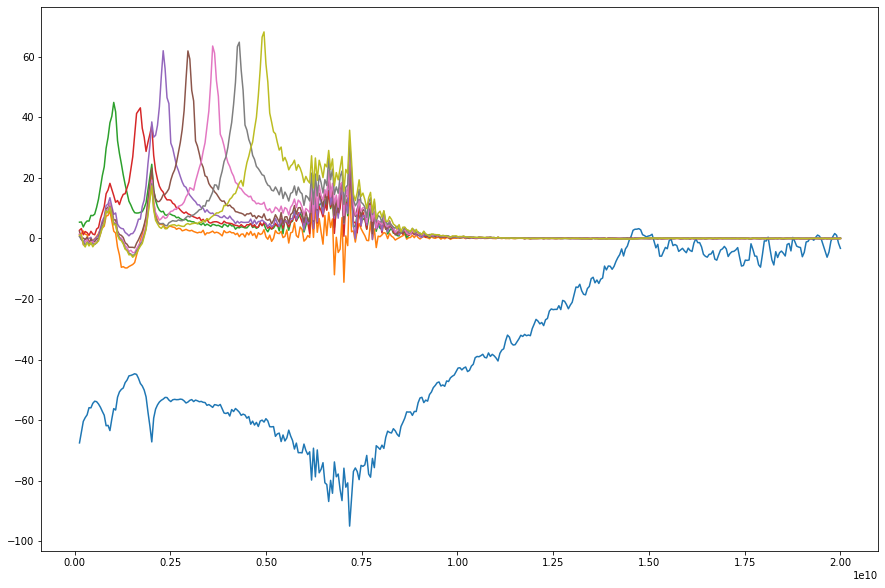

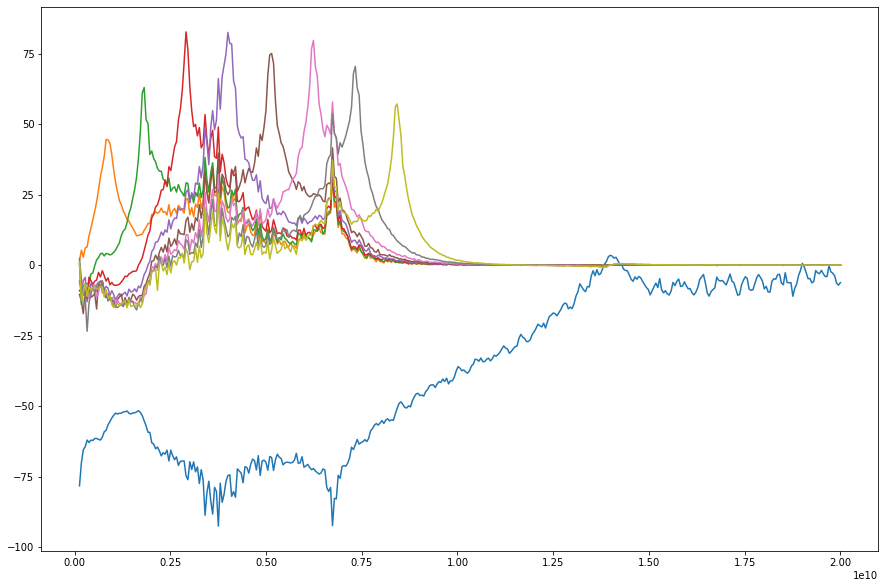

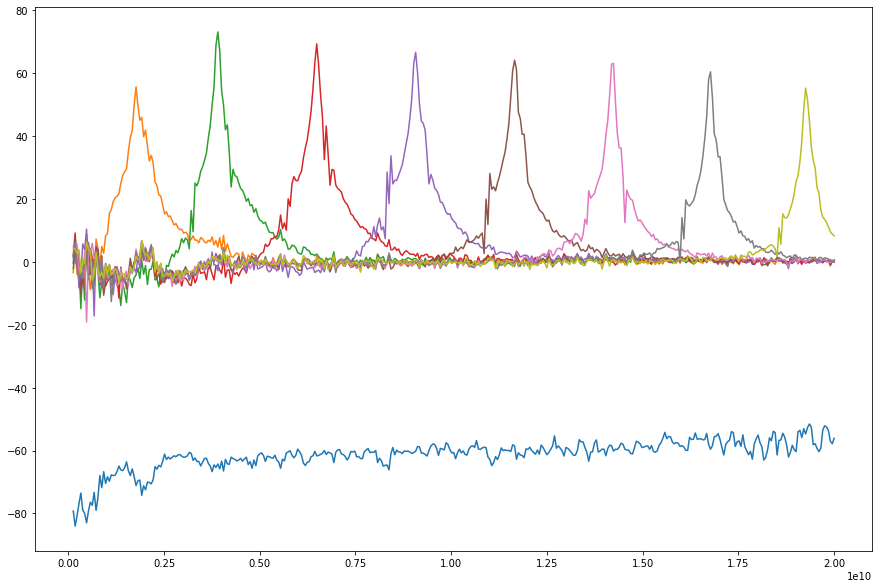

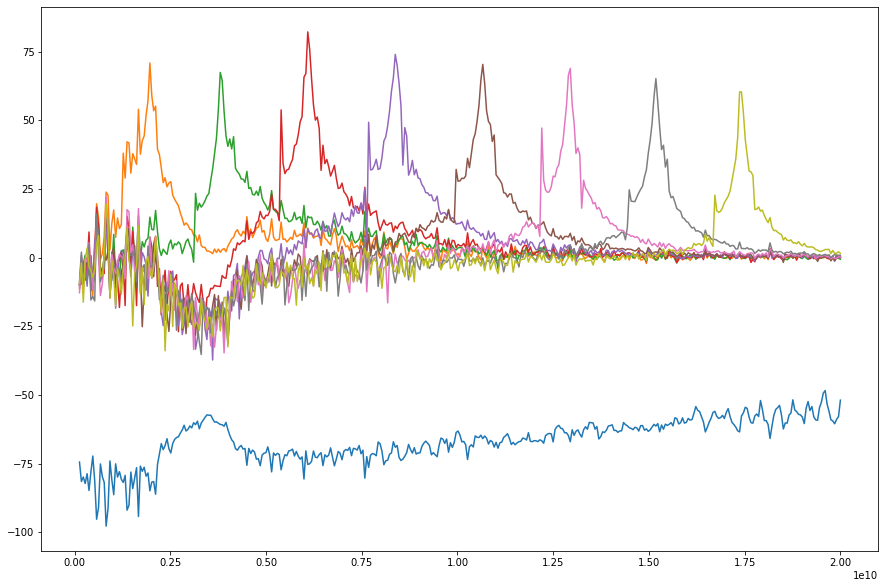

<Figure size 1080x720 with 0 Axes>

In [8]:
vna.setStartFrequency(130e6)
vna.setStopFrequency(20e9)
vna.setPoints(401)

fRanges=[]
for i in range(len(zeros)):
    print("Filter", i )
    fp = fParams[i]
    yc.switchA.set(i+1)
    yc.yigA.set(6, 0)
    fax = vna.frequencies()
    base = vna.readSParameter('S21')
    plt.plot(fax, 20*np.log10(np.abs(base)))
    sr = np.linspace(fp.lw, fp.hw, 8)
    freqs=[]
    
    for w in sr:
        yc.yigA.set(i, int(w))
        time.sleep(1)
        t = vna.readSParameter('S21')
        #traces.append(t)
        delt = np.abs(t)/np.abs(base)
        freqs.append(fax[np.argmax(delt)])
        plt.plot(fax, 20*np.log10(delt))
    mif=np.min(freqs)
    maf=np.max(freqs)
    #print(freqs)
    print(np.diff(freqs))
    fRanges.append((mif, maf))
    
    plt.figure()

for fmi, fma in fRanges:
    print("%f to %f [GHz]"%(fmi/1e9, fma/1e9))

import scipy.io as sio
sio.savemat('yig_filter_driver_coarse_frequency.mat', {'fRanges':fRanges})

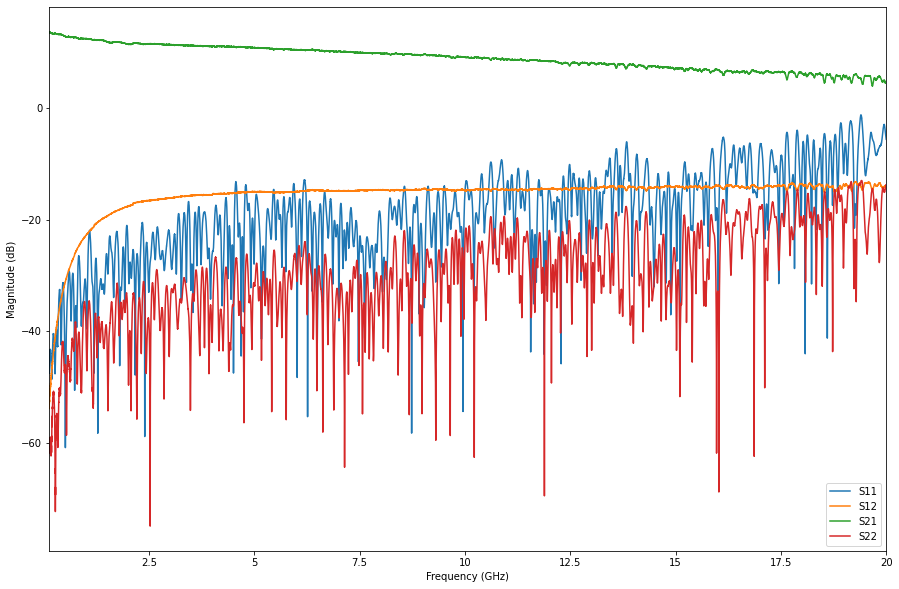

In [18]:
#Get calibration data
calPar=vna.getHighResolutionNetwork(130e6, 20e9, 1e6)
calPar.plot_s_db()
calPar.write_touchstone('cal_through.s2p')

In [14]:
import skrf.network

d=sio.loadmat('yig_filter_driver_current_data.mat')
zeros=d['zeros'][0]
channels=d['channels']
wr=d['wr'][0]

d2=sio.loadmat('yig_filter_driver_coarse_frequency.mat')
fRanges=d2['fRanges']
print(fRanges)
print(channels)
#print(wr)

for i in range(len(zeros)):
    fsta=fRanges[i,0]
    fsto=fRanges[i,1]
    print("Sweeping from %f to %f [GHz]"%(fsta/1e9, fsto/1e9))

[[4.2805000e+08 1.4215500e+09]
 [5.7707500e+08 4.2530250e+09]
 [1.0241500e+09 4.9484750e+09]
 [8.2545000e+08 8.4257250e+09]
 [1.7692750e+09 1.9254875e+10]
 [1.9679750e+09 1.7416900e+10]]
[[0.28665 0.28669 0.28684 ... 0.36464 0.36483 0.36503]
 [0.30225 0.30233 0.30235 ... 0.52359 0.52419 0.52469]
 [0.30697 0.3072  0.30739 ... 0.56562 0.56619 0.56671]
 [0.33447 0.33451 0.33453 ... 0.76147 0.76142 0.76148]
 [0.38563 0.38575 0.38572 ... 1.39479 1.39722 1.38968]
 [0.38617 0.38629 0.38627 ... 1.11389 1.1138  1.11374]]
Sweeping from 0.428050 to 1.421550 [GHz]
Sweeping from 0.577075 to 4.253025 [GHz]
Sweeping from 1.024150 to 4.948475 [GHz]
Sweeping from 0.825450 to 8.425725 [GHz]
Sweeping from 1.769275 to 19.254875 [GHz]
Sweeping from 1.967975 to 17.416900 [GHz]
